In [54]:
from neural_astar_jax.utils import data
from neural_astar_jax.utils import training
import matplotlib.pyplot as plt
import jax
from importlib import reload
from neural_astar_jax.planner import astar, differentiable_astar
reload(data)
reload(training)
reload(differentiable_astar)
reload(astar)
import optax
from flax.training.train_state import TrainState

In [55]:
dataloader = data.MazeDataLoader(filename="../../planning-datasets/data/mpd/mazes_032_moore_c8.npz", split="train", batch_size=100)
batch = dataloader.sample_batch(jax.random.PRNGKey(0))

In [56]:
planner = astar.NeuralAstar(is_training=True, search_step_ratio=0.05)
variables = planner.init(jax.random.PRNGKey(0), batch.map_design, batch.start_map, batch.goal_map)

In [57]:
class TrainStateBN(TrainState):
    batch_stats: dict

state = TrainStateBN.create(apply_fn=planner.apply, params=variables["params"], batch_stats=variables["batch_stats"], tx=optax.adam(learning_rate=0.001))


In [58]:
key = jax.random.PRNGKey(0)
for i in range(160):
    key1, key = jax.random.split(key)
    batch = dataloader.sample_batch(key1)
    loss, state, outputs, updates = training.step(batch, state, True)
    if i % 8 == 0:
        print(i, loss)

0 0.04392578
8 0.04915039
16 0.044902343
24 0.046875
32 0.046865232
40 0.04628906
48 0.047265623
56 0.042265624
64 0.044999998
72 0.045048825
80 0.047148436
88 0.048642576
96 0.045742188
104 0.048916016
112 0.044189453
120 0.047734372
128 0.04573242
136 0.04564453
144 0.04796875
152 0.049804688


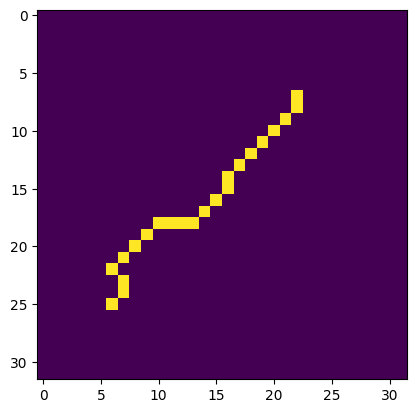

In [59]:
na = astar.NeuralAstar()
outputs = na.apply({"params": state.params, "batch_stats": state.batch_stats}, batch.map_design, batch.start_map, batch.goal_map)
plt.imshow(outputs.history[0])
plt.imshow(outputs.path_map[0], alpha=.5)

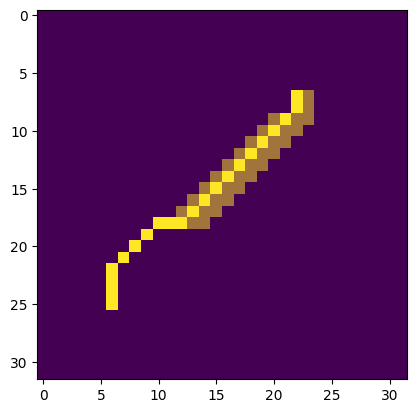

In [60]:
va = astar.VanillaAstar()
variables = va.init(jax.random.PRNGKey(0), batch.map_design, batch.start_map, batch.goal_map)
outputs2 = va.apply(variables, batch.map_design, batch.start_map, batch.goal_map)
plt.imshow(outputs2.history[0])
plt.imshow(outputs2.path_map[0], alpha=.5)

In [61]:
import jax.numpy as jnp
jnp.maximum((outputs2.history.sum((1, 2)) - outputs.history.sum((1, 2))) / outputs2.history.sum((1, 2)), 0).mean()

DeviceArray(0.44862577, dtype=float32)

In [62]:
(outputs.path_map.sum((1, 2)) == outputs2.path_map.sum((1, 2))).mean()

DeviceArray(0.61, dtype=float32)

In [23]:
from neural_astar.planner import NeuralAstar
na = NeuralAstar()
list(na.parameters())[2]

Parameter containing:
tensor([-0.0679, -0.1237, -0.0774,  0.1086,  0.1031, -0.1090,  0.2293,  0.2054,
         0.1451, -0.2291,  0.1453, -0.1206, -0.1693, -0.0017, -0.1134, -0.1288,
         0.1938,  0.0241,  0.1093, -0.1889,  0.1831, -0.1727, -0.1036, -0.2122,
         0.1064, -0.1171, -0.1279,  0.1549, -0.0782, -0.0780,  0.0084,  0.0433],
       requires_grad=True)

In [39]:
import flax.linen as nn
nn.Conv(3, (3, 3), bias_init=nn.initializers.variance_scaling)

Conv()

<function jax._src.nn.initializers.variance_scaling.<locals>.init(key: jax._src.prng.PRNGKeyArray, shape: Sequence[Union[int, Any]], dtype: Any = <class 'jax.numpy.float64'>) -> Any>